# Телеком — Определение неэффективных операторов

«Нупозвони» — провайдер виртуальный телефонии. Клиентами являются колл-центры, которые:
* распределяют входящие вызовы на операторов;
* совершают исходящие вызовы силами операторов.

Цель анализа: поиск неэффективных операторов.

Под неэффективностью будем понимать:
* много пропущенных внешних входящих вызовов (в случае, если был назначен оператор) - следует учесть общее число звонков (предварительно - более 10% от всех внешних входящих звонков);
* долгое ожидание ответа при входящих внешних вызовах (предварительно - более 1 минуты на звонок);
* мало исходящих вывозов — в случае колл-центров, специализирующихся на обзвонах, а не обработке входящих звонков (предварительно - менее 16 в день);
* большое количество исходящих внутренних вызовов (не пропущенных) - может указывать на недостаточные знания оператора (предварительно - более 50% от числа внешних звонков). <br>

Предварительные значения критериев неэффективности могут быть скорректированы с учетом средних значений для колл-центров.

Поскольку клиентами являются два вида колл-центров, необходимо их разделить. Для этого можно подсчитать процент входящих и исходящих внешних вызовов для каждого колл-центра и выбрать пороговое значение на основании полученного результата.

Статистические гипотезы, которые нужно проверить:
1. Средняя длительность внешних входящих звонков в колл-центрах, специализирующихся на обработке входящих звонков, равна средней длительности внешних исходящих звонков в колл-центрах, специализирующихся на обзвонах (без учета пропущенных звонков).
2. Среднее количество внешних звонков (без учета пропущенных) для каждого оператора составляет более 16 в день (более 2 в час при 8-часовом рабочем дне).

План анализа:
1. Предобработка данных
* загрузка и изучение
* дубликаты, типы данных, пропуски
* добавление столбцов со средней продолжительностью звонка и средней длительностью ожидания звонка
* анализ выбросов
* разделение колл-центров по специализациям и добавление соответствующего столбца
2. Исследовательский анализ данных
3. Проверка статистических гипотез
* scipy.stats.ttest_ind()
* scipy.stats.ttest_1samp()
4. Поиск неэффективных операторов
* пропущенные вызовы
* долгий ответ
* количество исходящих звонков
* внутренние звонки
* самые неэффективные операторы по совокупности критериев

Исходные данные - датасет со следующими колонками:
- `user_id` - Идентификатор клиентского аккаунта колл-центра в сервисе;
- `date` - Дата статистики;
- `direction` - Направление вызовов (out - исходящий вызов, in — входящий вызов);
- `internal` - Является ли звонок внутренним звонком между операторами клиента;
- `operator_id` - Идентификатор оператора;
- `is_missed_call` - Является ли звонок пропущенным;
- `calls_count` - Количество звонков;
- `call_duration` - Длительность звонка (без учета времени ожидания);
- `total_call_duration` - Длительность звонка (с учетом времени ожидания).

## Предобработка данных

### Импорт библиотек

In [150]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st

### Загрузка и изучение данных

In [151]:
# загружаем данные
data = pd.read_csv('telecom_dataset.csv')

In [152]:
# первые 5 строк
data.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [153]:
# случайные 5 строк
data.sample(5, random_state=1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
48897,168187,2019-11-18 00:00:00+03:00,in,False,937810.0,False,6,272,319
37139,167626,2019-10-08 00:00:00+03:00,out,False,920414.0,True,57,0,1277
21927,167052,2019-10-11 00:00:00+03:00,out,False,904038.0,False,3,290,312
50342,168252,2019-11-07 00:00:00+03:00,in,False,940622.0,True,1,132,145
53859,168601,2019-11-20 00:00:00+03:00,out,False,952914.0,True,1,0,2


In [154]:
# общая информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Есть пропуски в столбцах internal и operator_id.<br>
Следует обратить внимание на форматы `date` и `operator_id`.

### Проверка дубликатов

In [155]:
#проверка наличия явных дубликатов
print('Количество дубликатов:', data.duplicated().sum())
print('Процент дубликатов: {:.2%}'.format(
    data.duplicated().sum() / data.shape[0]))

Количество дубликатов: 4900
Процент дубликатов: 9.09%


In [156]:
#удаление дубликатов
data = data.drop_duplicates()

if data.duplicated().sum() == 0:
    print('Дубликаты удалены')
else:
    print(f'Осталось дубликатов: {data.duplicated().sum()}')

Дубликаты удалены


### Обработка пропусков

**Столбец internal:**

In [157]:
data.query('internal.isna()')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18


In [158]:
print('Процент пропусков в типах вызова: {:.2%}'.format(
    data.query('internal.isna()').shape[0] / data.shape[0]))

Процент пропусков в типах вызова: 0.22%


**Столбец operator_id:**

In [159]:
data.query('operator_id.isna()')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


In [160]:
print('Процент пропусков в id оператора: {:.2%}'.format(
    data.query('operator_id.isna()').shape[0] / data.shape[0]))

Процент пропусков в id оператора: 15.22%


In [161]:
print('Процент пропусков в id оператора, при которых звонок пропущен: {:.2%}'.format(
    data.query('operator_id.isna() and is_missed_call == True').shape[0] /
    data.query('operator_id.isna()').shape[0]))

Процент пропусков в id оператора, при которых звонок пропущен: 98.48%


Для целей текущего исследования пропущенные вызовы, для которых не был назначен оператор, не представляют интереса.

Удаляем все пропуски.

In [162]:
data = data.dropna(subset = ['internal', 'operator_id'])

### Типы данных

В первую очередь необходимо привести столбец с датами к формату дат.

In [163]:
#количество уникальных значений
data['date'].nunique()

118

In [164]:
data['date'].unique()

array(['2019-08-05 00:00:00+03:00', '2019-08-06 00:00:00+03:00',
       '2019-08-07 00:00:00+03:00', '2019-08-08 00:00:00+03:00',
       '2019-08-09 00:00:00+03:00', '2019-08-12 00:00:00+03:00',
       '2019-08-13 00:00:00+03:00', '2019-08-14 00:00:00+03:00',
       '2019-08-15 00:00:00+03:00', '2019-08-16 00:00:00+03:00',
       '2019-08-19 00:00:00+03:00', '2019-08-20 00:00:00+03:00',
       '2019-08-21 00:00:00+03:00', '2019-08-22 00:00:00+03:00',
       '2019-08-23 00:00:00+03:00', '2019-08-26 00:00:00+03:00',
       '2019-08-27 00:00:00+03:00', '2019-08-28 00:00:00+03:00',
       '2019-08-29 00:00:00+03:00', '2019-08-30 00:00:00+03:00',
       '2019-09-02 00:00:00+03:00', '2019-09-03 00:00:00+03:00',
       '2019-09-04 00:00:00+03:00', '2019-09-05 00:00:00+03:00',
       '2019-09-06 00:00:00+03:00', '2019-09-09 00:00:00+03:00',
       '2019-09-10 00:00:00+03:00', '2019-09-11 00:00:00+03:00',
       '2019-09-12 00:00:00+03:00', '2019-09-13 00:00:00+03:00',
       '2019-09-16 00:00:

В столбце `date` содержатся 118 дат с одинаковыми временными отметками.

In [165]:
# приведем столбец с датами к формату дат
data['date'] = pd.to_datetime(data['date'])

Теперь приведем `operator_id` к целым числам.

In [166]:
# количество операторов
data['operator_id'].nunique()

1092

In [167]:
# посмотрим, есть ли дробные числа
data['operator_id'].map(lambda x: x.is_integer()).unique()

array([ True])

In [168]:
# изменим тип данных
data['operator_id'] = data['operator_id'].astype('int')

In [169]:
# повторно выведем общую информацию по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              41491 non-null  int64                                
 1   date                 41491 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            41491 non-null  object                               
 3   internal             41491 non-null  object                               
 4   operator_id          41491 non-null  int32                                
 5   is_missed_call       41491 non-null  bool                                 
 6   calls_count          41491 non-null  int64                                
 7   call_duration        41491 non-null  int64                                
 8   total_call_duration  41491 non-null  int64                                
dtypes: bool

### Добавление столбцов со средней продолжительностью звонка и средней длительностью ожидания звонка

In [170]:
# Средняя продолжительность звонка
data['mean_call_duration'] = round(data['call_duration'] / data['calls_count'], 1)

In [171]:
# Средняя длительность ожидания звонка
data['mean_wait_duration'] = round((data['total_call_duration'] - data['call_duration']) / 
                                   data['calls_count'], 1)

In [172]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_call_duration,mean_wait_duration
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0.0,1.7
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0.0,1.0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,10.0,8.0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0.0,8.3
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,1.5,13.0


### Анализ выбросов

**Число звонков**

In [173]:
# статистическая информация по количеству звонков
round(data['calls_count'].describe(), 2)

count    41491.00
mean        16.92
std         59.79
min          1.00
25%          1.00
50%          4.00
75%         14.00
max       4817.00
Name: calls_count, dtype: float64

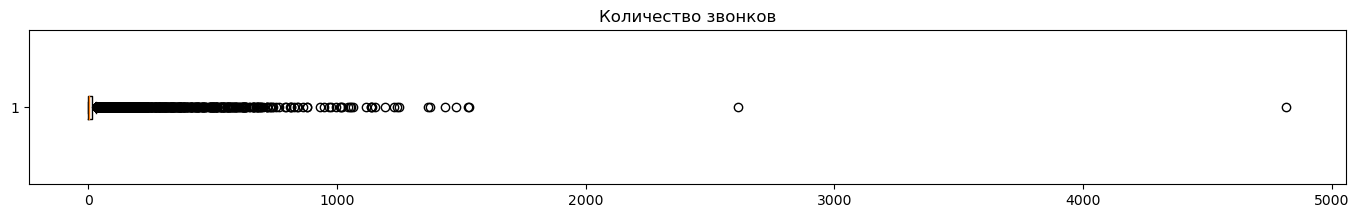

In [174]:
# boxplot-график распределения количества звонков (диаграмма размаха)
plt.figure(figsize=(17,2))
plt.boxplot(data['calls_count'], vert = False)
plt.title('Количество звонков')
plt.show()

In [175]:
print(np.percentile(data['calls_count'], [95, 99]))

[ 65.  165.1]


Только в 1% случаев оператор обрабатывает более 165 звонков одного типа в день.

In [176]:
# количество операторов, входящих в вышеуказанный 1%
data.query('calls_count > 165')['operator_id'].nunique()

22

In [177]:
data.query('calls_count > 1500')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_call_duration,mean_wait_duration
40671,167827,2019-10-31 00:00:00+03:00,out,False,929428,True,2614,0,45312,0.0,17.3
40680,167827,2019-11-01 00:00:00+03:00,out,False,929428,True,1529,0,28017,0.0,18.3
40690,167827,2019-11-05 00:00:00+03:00,out,False,929428,True,1533,0,27889,0.0,18.2
40733,167827,2019-11-11 00:00:00+03:00,out,False,929428,True,4817,0,5529,0.0,1.1


Видно много пропущенных исходящих звонков. Посмотрим на количество принятых вызовов.

In [178]:
round(data.query('is_missed_call == False')['calls_count'].describe(), 2)

count    27382.00
mean        15.70
std         49.71
min          1.00
25%          2.00
50%          4.00
75%         13.00
max       1480.00
Name: calls_count, dtype: float64

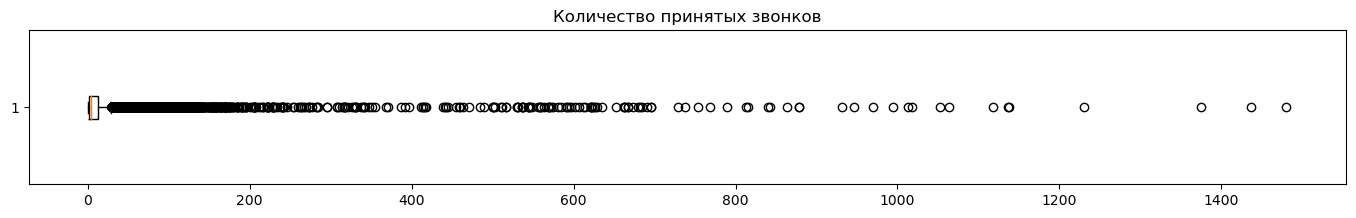

In [179]:
plt.figure(figsize=(17,2))
plt.boxplot(data.query('is_missed_call == False')['calls_count'], vert = False)
plt.title('Количество принятых звонков')
plt.show()

In [180]:
print(np.percentile(data.query('is_missed_call == False')['calls_count'], [95, 99]))

[ 61.   139.19]


Только в 1% случаев оператор принимает более 139 звонков в день.

In [181]:
# количество операторов, входящих в вышеуказанный 1%
data.query('is_missed_call == False and calls_count > 139')['operator_id'].nunique()

27

In [182]:
data.query('is_missed_call == False and calls_count > 1000')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_call_duration,mean_wait_duration
6745,166582,2019-09-02 00:00:00+03:00,out,False,885876,False,1018,90095,108665,88.5,18.2
6754,166582,2019-09-03 00:00:00+03:00,out,False,885876,False,1137,87700,109600,77.1,19.3
6808,166582,2019-09-09 00:00:00+03:00,out,False,885876,False,1138,121093,141930,106.4,18.3
6816,166582,2019-09-10 00:00:00+03:00,out,False,885876,False,1053,80782,100139,76.7,18.4
6874,166582,2019-09-17 00:00:00+03:00,out,False,885876,False,1375,100454,124787,73.1,17.7
6889,166582,2019-09-18 00:00:00+03:00,out,False,885876,False,1013,121664,140050,120.1,18.2
6923,166582,2019-09-23 00:00:00+03:00,out,False,885876,False,1436,103526,129484,72.1,18.1
6931,166582,2019-09-24 00:00:00+03:00,out,False,885876,False,1118,61814,82550,55.3,18.5
6946,166582,2019-09-25 00:00:00+03:00,out,False,885876,False,1230,144395,166155,117.4,17.7
6977,166582,2019-09-30 00:00:00+03:00,out,False,885876,False,1063,93800,112572,88.2,17.7


Операторы 929428 и 885876 демонстрируют аномальное поведение, выражающееся в неоднократном большом количестве звонков.

Сгруппируем данные по операторам и посмотрим на количество звонков.

In [183]:
round(data.groupby('operator_id')['calls_count'].mean().describe(), 2)

count    1092.00
mean       11.86
std        26.32
min         1.00
25%         1.61
50%         2.92
75%         9.60
max       365.45
Name: calls_count, dtype: float64

In [184]:
data.groupby('operator_id')['calls_count'].mean().sort_values(ascending=False)

operator_id
929428    365.446154
908640    331.139535
925922    274.260274
885890    238.027668
885876    209.996466
             ...    
909768      1.000000
909392      1.000000
948282      1.000000
948284      1.000000
909896      1.000000
Name: calls_count, Length: 1092, dtype: float64

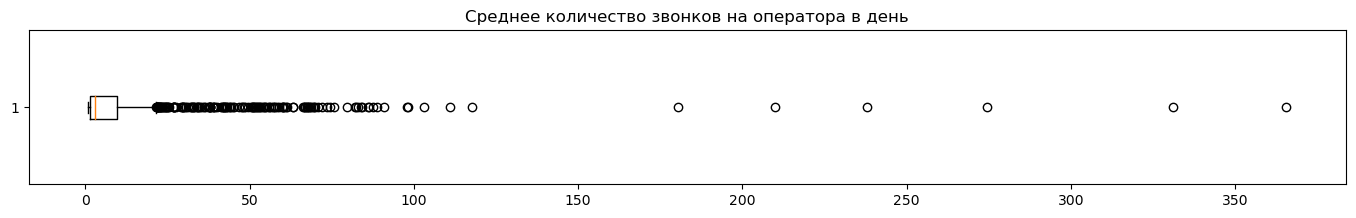

In [185]:
plt.figure(figsize=(17,2))
plt.boxplot(data.groupby('operator_id')['calls_count'].mean(), vert = False)
plt.title('Среднее количество звонков на оператора в день')
plt.show()

In [186]:
print(np.percentile(data.groupby('operator_id')['calls_count'].mean(), [95, 99]))

[55.80662285 91.55958245]


Только в 1% случаев оператор обрабатывает более 91 звонка в день.

In [187]:
# шесть операторов с наибольшим средним количеством звонков в день
data.groupby('operator_id')['calls_count'].mean().sort_values(ascending=False).head(6)

operator_id
929428    365.446154
908640    331.139535
925922    274.260274
885890    238.027668
885876    209.996466
929426    180.467742
Name: calls_count, dtype: float64

In [188]:
# медианная длительность принятого звонка
data.query('is_missed_call == False')['mean_call_duration'].median()

80.2

При длительности звонка в 1,5 минуты, за 8-часовой рабочий день можно сделать 320 звонков. Таким образом, среднее количество звонков, равное 365 (включая пропущенные), является возможным.

Удалим двух ранее выявленных аномальных операторов.

In [189]:
data = data.query('operator_id != 929428 and operator_id != 885876')

**Длительность звонка**

In [190]:
# статистическая информация по средней длине принятых звонков
data.query('is_missed_call == False')['mean_call_duration'].describe()

count    27181.000000
mean       116.760035
std        146.182125
min          0.000000
25%         43.500000
50%         80.200000
75%        135.400000
max       3550.000000
Name: mean_call_duration, dtype: float64

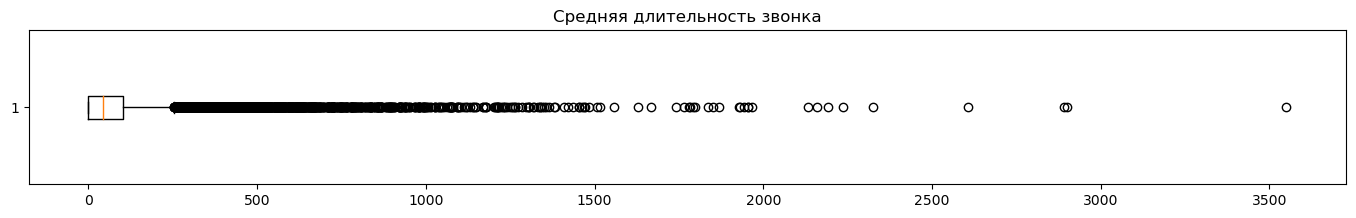

In [191]:
plt.figure(figsize=(17,2))
plt.boxplot(data['mean_call_duration'], vert = False)
plt.title('Средняя длительность звонка')
plt.show()

3550 секунд - это 59 минут.

In [192]:
data.groupby('operator_id')['mean_call_duration'].median().sort_values(ascending=False).head(10)

operator_id
891192    1306.00
917890     647.00
899906     626.00
899898     590.00
918390     513.65
909452     424.20
939236     412.00
969600     408.25
910926     398.50
890232     379.00
Name: mean_call_duration, dtype: float64

В данных присутствуют выбросы, но они не являются аномальными.

**Длительность ожидания**

In [193]:
# статистическая информация по среднему времени ожидания
data['mean_wait_duration'].describe()

count    41143.000000
mean        16.517549
std         11.961154
min          0.000000
25%          8.400000
50%         14.600000
75%         21.700000
max        451.200000
Name: mean_wait_duration, dtype: float64

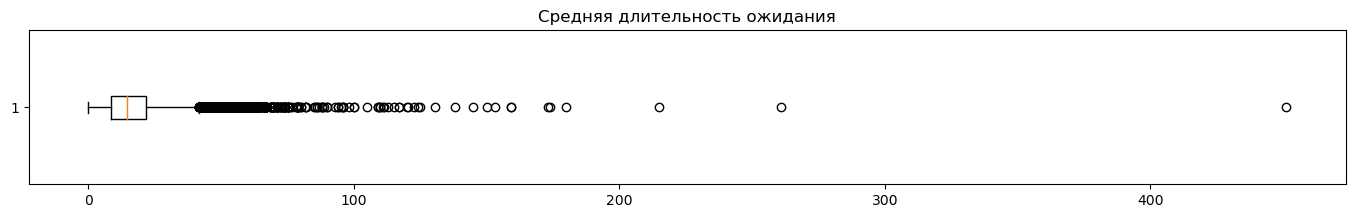

In [194]:
plt.figure(figsize=(17,2))
plt.boxplot(data['mean_wait_duration'], vert = False)
plt.title('Средняя длительность ожидания')
plt.show()

Аналогично с длительностью звонков, в значениях средней длительности ожидания присутствуют выбросы, но они не являются аномальными.

**Вывод:** удалены два оператора с аномальным поведением, выбросы оставлены. 

### Разделение колл-центров по специализациям

In [195]:
# количество колл-центров
data['user_id'].nunique()

290

Создадим таблицу specialization с количеством входящих и исходящих звонков для каждого колл-центра за все время, пропуски заполним нулями.

In [196]:
specialization = data.pivot_table(
    index='user_id', columns='direction', values='calls_count', aggfunc='sum', fill_value=0)

In [197]:
#data.groupby('user_id')['calls_count'].sum()

In [198]:
# добавим столбец с общим количеством звонков
specialization['all'] = data.groupby('user_id')['calls_count'].sum()

Вытащим user_id	из индекса в отдельный столбец и добавим столбцы с процентным соотношением входящих и исходящих вызовов от общего числа звонков.

In [199]:
specialization['in_%'] = round(specialization['in'] / specialization['all'] * 100, 2)
specialization['out_%'] = round(specialization['out'] / specialization['all'] * 100, 2)
# сортировка
specialization = specialization.sort_values(by='in_%')
# обновим значения индексов
specialization = specialization.reset_index()

In [200]:
specialization

direction,user_id,in,out,all,in_%,out_%
0,167125,0,14608,14608,0.0,100.0
1,167455,0,246,246,0.0,100.0
2,167645,0,679,679,0.0,100.0
3,167716,0,733,733,0.0,100.0
4,168603,0,14,14,0.0,100.0
...,...,...,...,...,...,...
285,168016,8,0,8,100.0,0.0
286,166879,256,0,256,100.0,0.0
287,166837,42,0,42,100.0,0.0
288,167242,2,0,2,100.0,0.0


Построим график соотношения входящих и исходящих звонков для колл-центров.

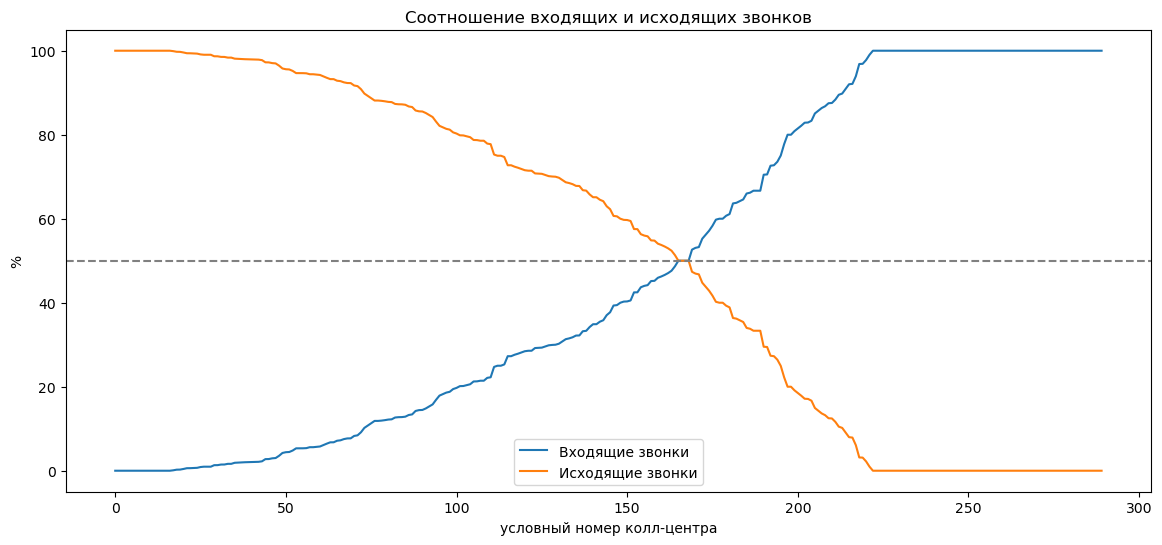

In [201]:
plt.figure(figsize=(14,6))

plt.plot(specialization.index, specialization['in_%'], label='Входящие звонки')
plt.plot(specialization.index, specialization['out_%'], label='Исходящие звонки')
plt.axhline(y=50, color='grey', linestyle='--')

plt.title('Соотношение входящих и исходящих звонков')
plt.xlabel('условный номер колл-центра')
plt.ylabel('%')
plt.legend()
plt.show()

Создадим списки специализированных колл-центров. Примем, что если входящих звонков половина или больше, то колл-центр специализируется на обработке входящих звонков.

In [202]:
specialization_in = specialization[specialization['in_%'] >= 50]['user_id']
specialization_out = specialization[specialization['in_%'] < 50]['user_id']

In [203]:
# проверка правильности разбивки на группы
if len(specialization_in) + len(specialization_out) == data['user_id'].nunique():
    print('Разбивка на группы верна')
else:
    print('Количество колл-центров в группах неверно')

Разбивка на группы верна


Добавим в data столбец со специализацией колл-центра (type: in/out).

In [204]:
data['type'] = data['user_id'].map(lambda x: 'in' if x in specialization_in.to_list() else 'out')

In [205]:
data.sample(2, random_state=1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_call_duration,mean_wait_duration,type
15329,166896,2019-11-06 00:00:00+03:00,in,False,895576,True,1,0,23,0.0,23.0,in
34231,167497,2019-11-12 00:00:00+03:00,out,True,921116,False,3,581,596,193.7,5.0,out


### Результаты предобработки

По результатам предобработки: 
- удалены дубликаты, пропуски в типах вызова и в id оператора;
- исправлены типы данных;
- добавлены столбцы со средней продолжительностью звонка и средней длительностью ожидания звонка;
- проанализированы выбросы и удалены аномалии;
- произведено разделение колл-центров по специализациям и добавлен соответствующий столбец.

## Исследовательский анализ данных

In [206]:
#data.sample(random_state=1)

In [207]:
print('Начальная дата: ', data['date'].dt.date.min())
print('Конечная дата: ', data['date'].dt.date.max())
print('Количество дней: ', data['date'].dt.date.nunique())

Начальная дата:  2019-08-02
Конечная дата:  2019-11-28
Количество дней:  118


In [208]:
print('Количество колл-центров: ', data['user_id'].nunique())
print('Количество операторов: ', data['operator_id'].nunique())

Количество колл-центров:  290
Количество операторов:  1090


В датасете содержатся данные с 02.08.2019 по 28.11.2019 в отношении 290 колл-центров и 1090 операторов.

---

**Количество дней, за которые имеются данные по колл-центрам:**

In [209]:
print('Минимальное количество дней: ', data.groupby('user_id')['date'].nunique().min())
print('Максимальное количество дней: ', data.groupby('user_id')['date'].nunique().max())
print('Медианное количество дней: ', round(data.groupby('user_id')['date'].nunique().median()))

Минимальное количество дней:  1
Максимальное количество дней:  98
Медианное количество дней:  22


In [210]:
data.groupby('user_id')['date'].nunique().describe()

count    290.000000
mean      29.565517
std       24.490324
min        1.000000
25%        9.000000
50%       22.500000
75%       46.000000
max       98.000000
Name: date, dtype: float64

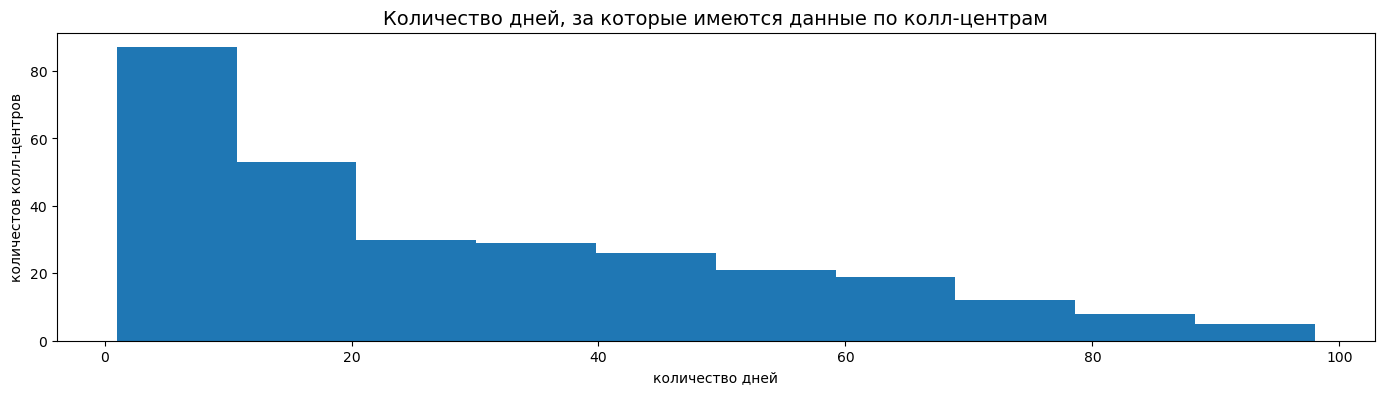

In [211]:
# график распределения количества дней, за которые имеются данные по колл-центрам
plt.figure(figsize=(17,4))
data.groupby('user_id')['date'].nunique().plot(kind='hist', bins=10)
plt.title('Количество дней, за которые имеются данные по колл-центрам', fontsize=14)
plt.xlabel('количество дней')
plt.ylabel('количестов колл-центров')
plt.show()

В отношении половины колл-центров имеются данные не более чем за 22 дня. Колл-центров, данные по которым имеются за весь период исследования (118 дней), нет.

In [212]:
# таблица с минимальной и макисмальной датами звонков
dates = data.pivot_table(index='user_id', values='date', aggfunc=['min', 'max'])
dates.columns = ['min_date', 'max_date']

dates.head(1)

,min_date,max_date
user_id,,
166377,2019-08-05 00:00:00+03:00,2019-11-28 00:00:00+03:00


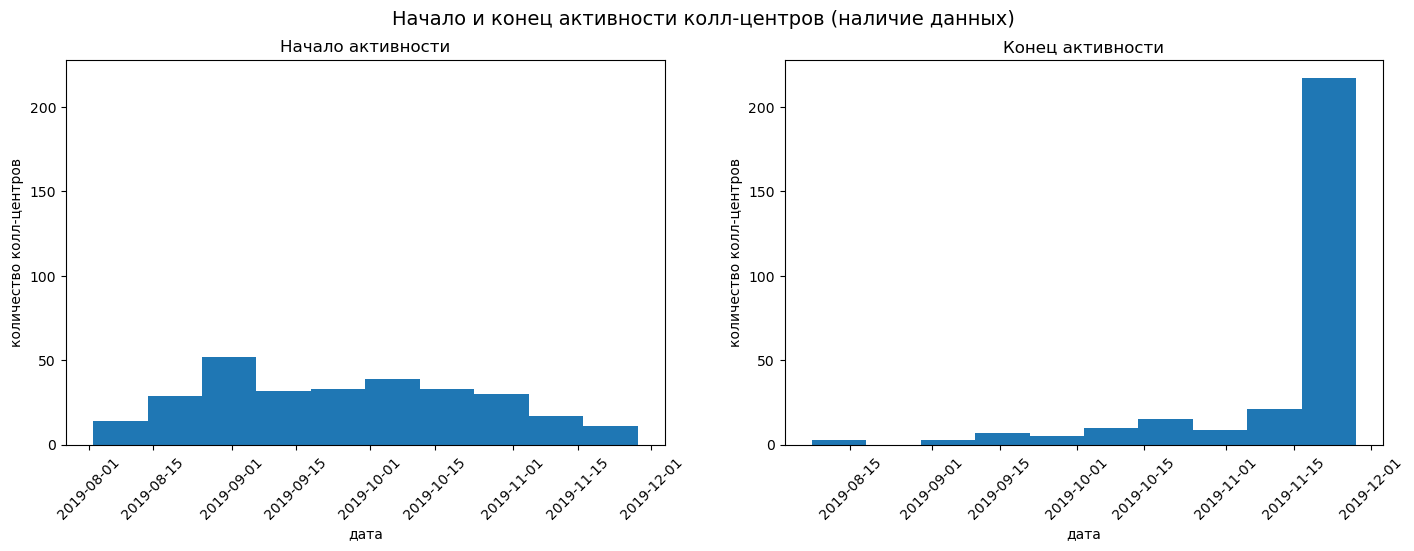

In [213]:
# два графика рядом

plt.figure(figsize=(17,5))
plt.suptitle('Начало и конец активности колл-центров (наличие данных)', fontsize=14)

ax1 = plt.subplot(1, 2, 1)
ax1.hist(dates['min_date'])
plt.title('Начало активности')
plt.xlabel('дата')
plt.ylabel('количество колл-центров')
plt.xticks(rotation=45)

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
ax2.hist(dates['max_date'])
plt.title('Конец активности')
plt.xlabel('дата')
plt.ylabel('количество колл-центров')
plt.xticks(rotation=45)

plt.show()

Присоединение колл-центров происходило равномерно в течение всего периода исследования. На момент окончания исследования большинство колл-центров оставались активными.

---

In [214]:
data.groupby('operator_id')['user_id'].nunique().unique()

array([1], dtype=int64)

В датасете отсутствуют ошибки, связанные с нахождением оператора сразу в нескольких колл-центрах.

---

**Общее соотношение внутренних и внешних звонков.**

In [215]:
data.pivot_table(index='internal', values='calls_count', aggfunc='sum').reset_index()

,internal,calls_count
0,False,605240
1,True,13662


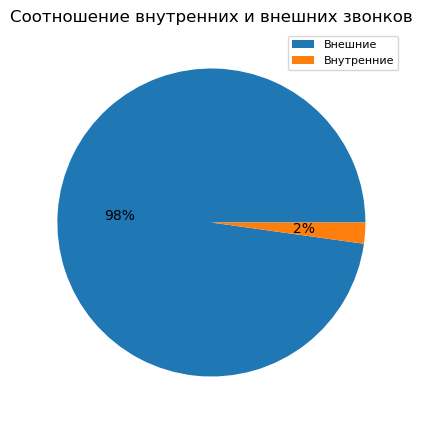

In [216]:
# Круговая диаграмма
plt.figure(figsize=(7,5))
plt.pie(data.pivot_table(index='internal', values='calls_count', aggfunc='sum').reset_index()['calls_count'], 
        autopct='%1.0f%%')
plt.title('Соотношение внутренних и внешних звонков', fontsize=12)
plt.legend(['Внешние', 'Внутренние'], fontsize=8)
plt.show()

98% звонков являются внешними.

Детализация внутренних звонков:

In [217]:
data.query('internal==True').pivot_table(index='direction', values='calls_count', aggfunc='sum')

,calls_count
direction,
in,691
out,12971


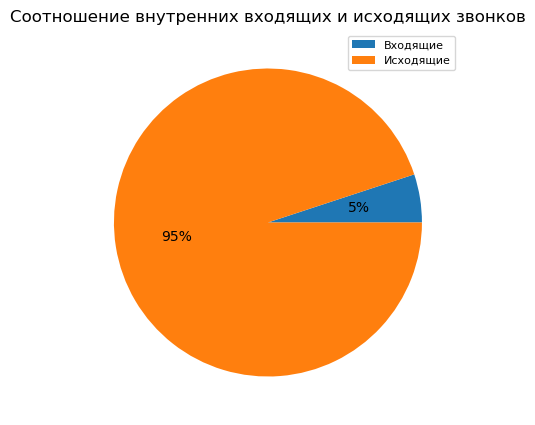

In [218]:
plt.figure(figsize=(7,5))
plt.pie(data.query('internal==True')
        .pivot_table(index='direction', values='calls_count', aggfunc='sum')
        .reset_index()['calls_count'], 
        autopct='%1.0f%%')
plt.title('Соотношение внутренних входящих и исходящих звонков', fontsize=12)
plt.legend(['Входящие', 'Исходящие'], fontsize=8)
plt.show()

95% внутренних звонков являются исходящими.

---

**Звонки: входящие и исходящие, пропущенные и принятые**

In [219]:
missed_calls = pd.DataFrame(
    data.groupby(['is_missed_call', 'direction'], as_index=False)['calls_count'].sum()
)
missed_calls

,is_missed_call,direction,calls_count
0,False,in,91845
1,False,out,297187
2,True,in,905
3,True,out,228965


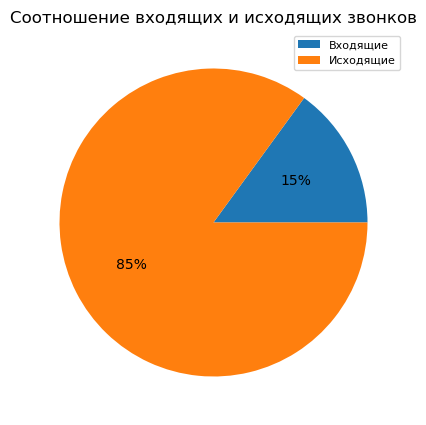

In [220]:
plt.figure(figsize=(7,5))
plt.pie(missed_calls.groupby('direction')['calls_count'].sum(), 
        autopct='%1.0f%%')
plt.title('Соотношение входящих и исходящих звонков', fontsize=12)
plt.legend(['Входящие', 'Исходящие'], fontsize=8)
plt.show()

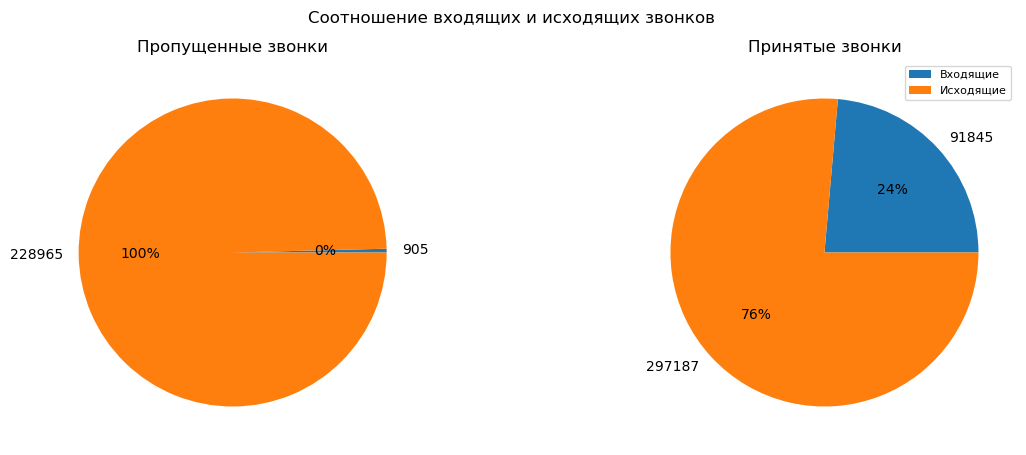

In [221]:
plt.figure(figsize=(14,5))
plt.suptitle('Соотношение входящих и исходящих звонков', fontsize=12)

ax1 = plt.subplot(1, 2, 1)
ax1.pie(missed_calls.query('is_missed_call == True')['calls_count'], 
        autopct='%1.0f%%', labels=missed_calls.query('is_missed_call == True')['calls_count'])
plt.title('Пропущенные звонки')

ax2 = plt.subplot(1, 2, 2)
ax2.pie(missed_calls.query('is_missed_call == False')['calls_count'],
        autopct='%1.0f%%', labels=missed_calls.query('is_missed_call == False')['calls_count'])
plt.title('Принятые звонки')

plt.legend(['Входящие', 'Исходящие'], loc='upper right', fontsize=8)

plt.show()

In [222]:
#missed_calls.groupby('is_missed_call')['calls_count'].sum()

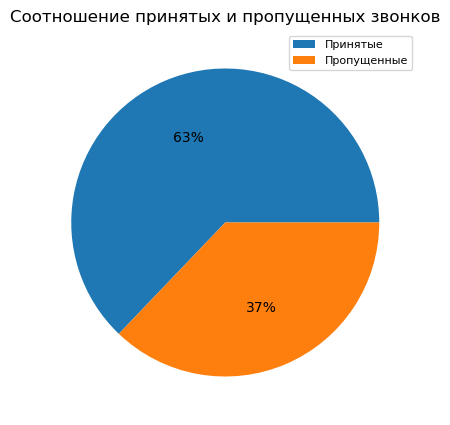

In [223]:
plt.figure(figsize=(7,5))
plt.pie(missed_calls.groupby('is_missed_call')['calls_count'].sum(), 
        autopct='%1.0f%%')
plt.title('Соотношение принятых и пропущенных звонков', fontsize=12)
plt.legend(['Принятые', 'Пропущенные'], fontsize=8)
plt.show()

85% всех звонков являются исходящими (76%, если не считать пропущенные).<br>
Пропущенные звонки составляют 37% от общего количества. Практически все пропущенные звонки являются исходящими. 

---

**Специализация колл-центров**

In [224]:
#data.groupby(['type'])['user_id'].nunique()

In [225]:
# построение круговой диаграммы
''' принимает на вход название столбца и заголовок
    выводит круговую диаграмму соотношения
    значений в разрезе специализации колл-центров
''' 

def spec_pie(column, title):
    plt.figure(figsize=(7,5))
    plt.pie(data.groupby(['type'])[column].nunique(), 
        autopct='%1.0f%%')
    plt.title(title, fontsize=12)
    plt.legend(['Прием звонков', 'Обзвоны'], fontsize=8)
    plt.show()

In [226]:
#plt.figure(figsize=(7,7))
#plt.pie(data.groupby(['type'])['user_id'].nunique(), 
#        autopct='%1.0f%%')
#plt.title('Специализация колл-центров', fontsize=14)
#plt.legend(['Прием звонков', 'Обзвоны'], fontsize=10)
#plt.show()

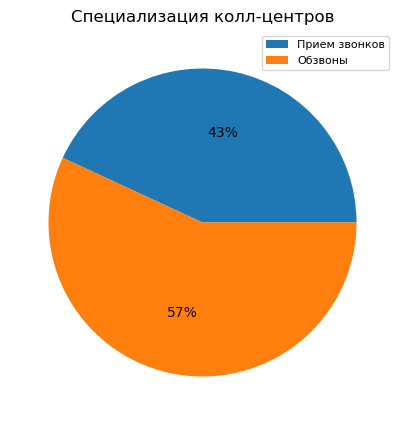

In [227]:
spec_pie('user_id', 'Специализация колл-центров')

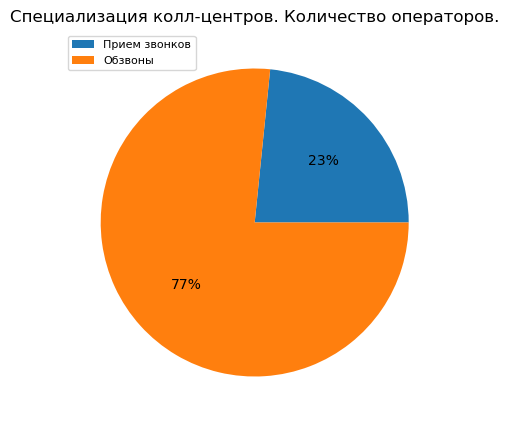

In [228]:
spec_pie('operator_id', 'Специализация колл-центров. Количество операторов.')

In [229]:
# количество операторов по типу колл-центров
data.groupby('type')['operator_id'].nunique()

type
in     255
out    835
Name: operator_id, dtype: int64

In [230]:
# количество колл-центров по типу
data.groupby('type')['user_id'].nunique()

type
in     125
out    165
Name: user_id, dtype: int64

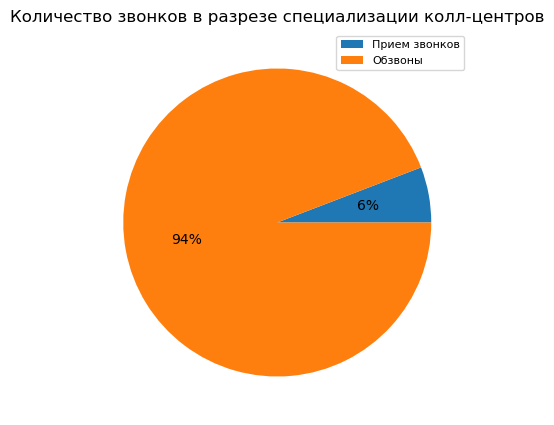

In [231]:
plt.figure(figsize=(7,5))
plt.pie(data.groupby('type')['calls_count'].sum(), 
        autopct='%1.0f%%')
plt.title('Количество звонков в разрезе специализации колл-центров', fontsize=12)
plt.legend(['Прием звонков', 'Обзвоны'], fontsize=8)
plt.show()

Специализации колл-центров в датасете представлены практически равным количеством колл-центров (43% / 57%). При этом, 77% операторов относятся к колл-центрам, специализирующиеся на обзвонах. Также такие колл-центры совершают 94% от всех звонков. 

In [232]:
# Среднее количество операторов в разрезе по типу колл-центров
pd.DataFrame(
    round(
        data.pivot_table(
            index='type', columns='user_id', 
            values='operator_id', aggfunc='nunique')
        .agg('mean', axis=1), 2
    )
).rename(columns={0:'operator_id_mean'})

,operator_id_mean
type,
in,2.04
out,5.06


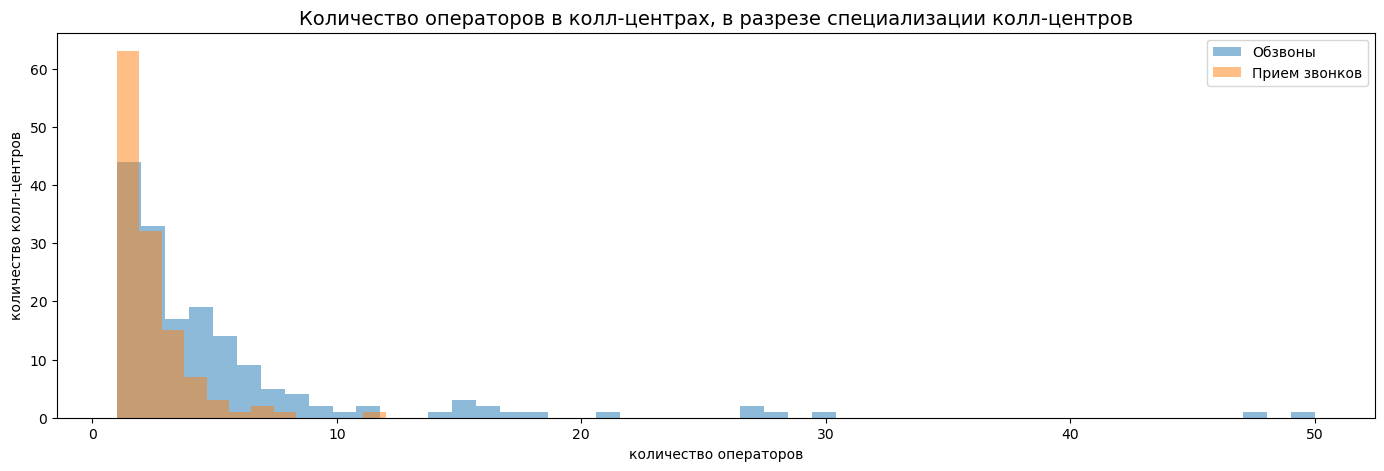

In [233]:
plt.figure(figsize=(17,5))

data.pivot_table(
    index='user_id', columns='type', 
    values='operator_id', aggfunc='nunique')['out'].plot(
    kind='hist', alpha=0.5, bins=50)

data.pivot_table(
    index='user_id', columns='type', 
    values='operator_id', aggfunc='nunique')['in'].plot(
    kind='hist', alpha=0.5, bins=12)

plt.title('Количество операторов в колл-центрах, в разрезе специализации колл-центров', fontsize=14)
plt.legend(['Обзвоны', 'Прием звонков'], loc='upper right', fontsize=10)
plt.xlabel('количество операторов')
plt.ylabel('количество колл-центров')
plt.show()

In [234]:
# количество операторов в самом крупном колл-центре (обзвоны)
data.pivot_table(
    index='user_id', columns='type', 
    values='operator_id', aggfunc='nunique')['out'].max()

50.0

In [235]:
# количество операторов в самом крупном колл-центре (прием звонков)
data.pivot_table(
    index='user_id', columns='type', 
    values='operator_id', aggfunc='nunique')['in'].max()

12.0

В среднем, в колл-центрах, специализирующихся на обзвонах, работают 5 операторов, а в колл-центрах, специализирующихся на приеме звонков - 2 оператора. Самые крупные колл-центры имеют соответственно 50 и 12 операторов.

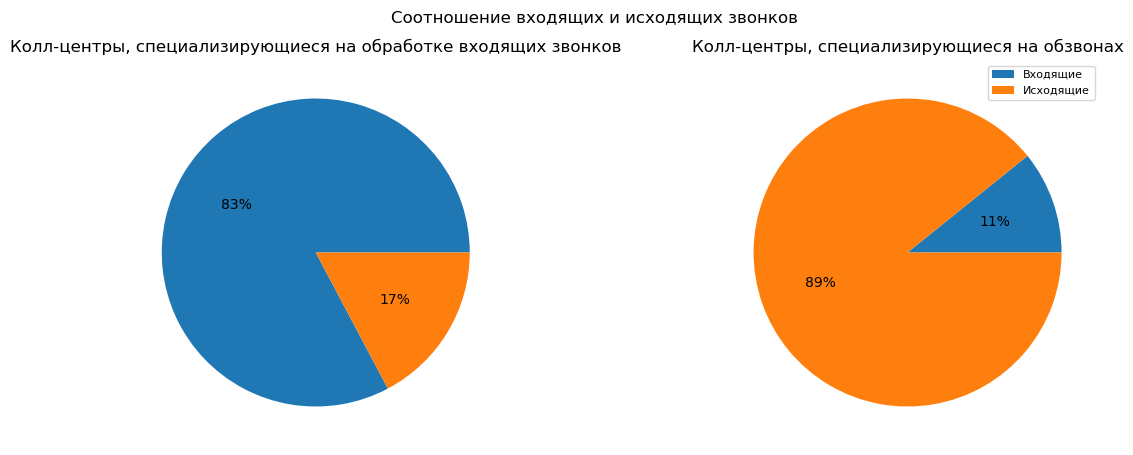

In [236]:
# Соотношение входящих и исходящих звонков по типам колл-центров
plt.figure(figsize=(14,5))
plt.suptitle('Соотношение входящих и исходящих звонков', fontsize=12)

ax1 = plt.subplot(1, 2, 1)
ax1.pie(data.query('type == "in"').groupby('direction')['calls_count'].sum(), 
        autopct='%1.0f%%')
plt.title('Колл-центры, специализирующиеся на обработке входящих звонков')

ax2 = plt.subplot(1, 2, 2)
ax2.pie(data.query('type == "out"').groupby('direction')['calls_count'].sum(),
   autopct='%1.0f%%')
plt.title('Колл-центры, специализирующиеся на обзвонах')

plt.legend(['Входящие', 'Исходящие'], loc='upper right', fontsize=8)

plt.show()

В соотношении входящих и исходящих звонков явно заметна специализация колл-центров.

---

**Количество звонков**

Посчитаем среднее количество входящих и исходящих звонков в день на оператора (без учета пропущенных).

In [237]:
calls = pd.DataFrame(
    round(data.query('is_missed_call == False').pivot_table(
        index=['direction', 'internal'], columns='operator_id', 
        values='calls_count', aggfunc='mean')
        .agg('mean', axis=1), 2
         )
).reset_index().rename(columns={0:'calls_count_mean'})
calls

,direction,internal,calls_count_mean
0,in,False,4.87
1,in,True,1.70
2,out,False,17.78
3,out,True,2.07


In [238]:
# преобразуем таблицу для построения графика
calls_graph = calls.pivot_table(index='direction', columns='internal', values='calls_count_mean')
calls_graph.index = ['входящие', 'исходящие']
calls_graph.columns = ['внешние', 'внутренние']
calls_graph

,внешние,внутренние
входящие,4.87,1.70
исходящие,17.78,2.07


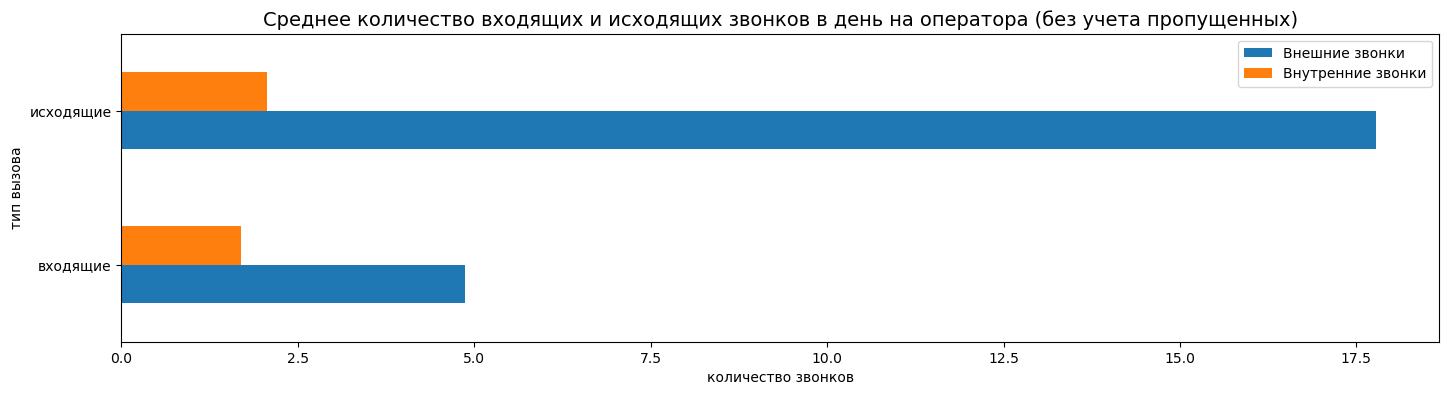

In [239]:
calls_graph.plot(kind='barh', figsize=(17,4))
plt.title('Среднее количество входящих и исходящих звонков в день на оператора (без учета пропущенных)', fontsize=14)
plt.legend(['Внешние звонки', 'Внутренние звонки'], fontsize=10)
plt.xlabel('количество звонков')
plt.ylabel('тип вызова')
plt.show()

Среднее количество исходящих внешних звонков в день на оператора более чем в три раза выше, чем аналогичных входящих звонков - 17,8 против 4,9.

---

**Средняя длительность звонков**

In [240]:
data.query('is_missed_call == False')['mean_call_duration'].describe()

count    27181.000000
mean       116.760035
std        146.182125
min          0.000000
25%         43.500000
50%         80.200000
75%        135.400000
max       3550.000000
Name: mean_call_duration, dtype: float64

In [241]:
call_duration = data.query('is_missed_call == False').pivot_table(
    index='direction', columns='internal', values='mean_call_duration', aggfunc=['median'])
call_duration.index = ['входящие', 'исходящие']
call_duration.columns = ['Внешние', 'Внутренние']
call_duration

,Внешние,Внутренние
входящие,84.6,33.0
исходящие,85.2,39.0


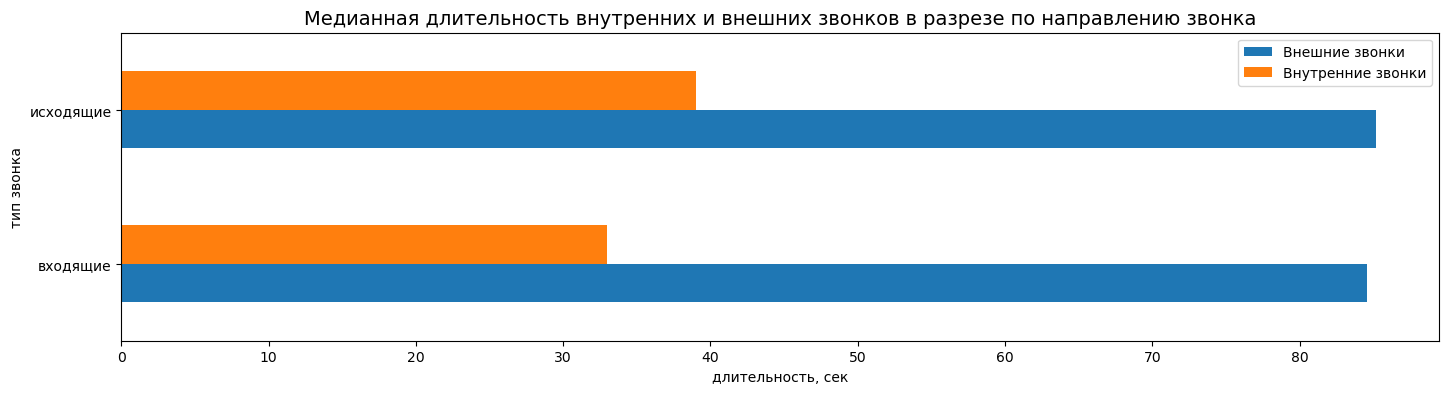

In [242]:
call_duration.plot(kind='barh', figsize=(17,4))

plt.title('Медианная длительность внутренних и внешних звонков в разрезе по направлению звонка', fontsize=14)
plt.legend(['Внешние звонки', 'Внутренние звонки'], fontsize=10)
plt.xlabel('длительность, сек')
plt.ylabel('тип звонка')
plt.show()

Медианная длительность звонка составляет 80,2 секунд. Медианная длительность внешних входящих и исходящих звонков примерно равна, длительность внутренних исходящих звонков больше, чем входящих.

---

**Время ожидания звонка**

In [243]:
data.query('internal==False')['mean_wait_duration'].describe()

count    35815.000000
mean        17.632813
std         11.865507
min          0.000000
25%         10.000000
50%         15.600000
75%         22.700000
max        451.200000
Name: mean_wait_duration, dtype: float64

In [244]:
data.query('internal==False').pivot_table(
    index='direction', values='mean_wait_duration', aggfunc=['median'])

,median
,mean_wait_duration
direction,
in,13.0
out,16.5


Медианное время ожидания внешнего звонка составляет 15,6 сек., при входящем вызове - 13 сек., при исходящем - 16,5 сек.

---

## Проверка статистических гипотез

### Гипотеза о равенстве длительности входящих и исходящих звонков

Нулевая гипотеза: средняя длительность внешних входящих звонков в колл-центрах, специализирующихся на обработке входящих звонков, равна средней длительности внешних исходящих звонков в колл-центрах, специализирующихся на обзвонах (без учета пропущенных звонков). <br>

Альтернативная гипотеза: средняя длительность внешних входящих звонков в колл-центрах, специализирующихся на обработке входящих звонков, не равна средней длительности внешних исходящих звонков в колл-центрах, специализирующихся на обзвонах (без учета пропущенных звонков).

Метод scipy.stats.ttest_ind (array1, array2, equal_var) проверяет гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

In [245]:
# создадим выборки для проверки гипотезы
calls_in = data.query(
    'is_missed_call==False and internal==False \
     and direction=="in" and type=="in"')['mean_call_duration']
print(calls_in.head(3))

calls_out = data.query(
    'is_missed_call==False and internal==False \
     and direction=="out" and type=="out"')['mean_call_duration']
print(calls_out.head(3))

571    175.0
574     57.0
584      4.0
Name: mean_call_duration, dtype: float64
5       1.5
13    160.0
15     21.0
Name: mean_call_duration, dtype: float64


In [246]:
alpha = 0.01 #критический уровень статистической значимости
# проведем t-тест
results = st.ttest_ind(calls_in, 
                       calls_out, 
                       equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.940741985127255e-17
Отвергаем нулевую гипотезу


In [247]:
print('Cредняя длительность внешних входящих звонков в колл-центрах, специализирующихся на обработке входящих звонков (сек.):', 
      round(calls_in.mean(), 2))
print('Cредняя длительность исходящих звонков в колл-центрах, специализирующихся на обзвонах (сек.):', 
      round(calls_out.mean(), 2))

Cредняя длительность внешних входящих звонков в колл-центрах, специализирующихся на обработке входящих звонков (сек.): 111.03
Cредняя длительность исходящих звонков в колл-центрах, специализирующихся на обзвонах (сек.): 133.15


Гипотеза о равенстве длительности входящих и исходящих звонков отвергнута. Разница средней длительности входящих (111 сек.) и исходящих (133 сек.) звонков оказалась статистически значимой.

In [248]:
# функция строит гистограмму, ограничение x=500
# call = calls_in / calls_out

def hist_timecall(call, title):
    plt.figure(figsize=(17,4))
    call.plot(kind='hist', bins=200)
    plt.title(title, fontsize=14)
    plt.xlabel('средняя длительность звонка, сек.')
    plt.ylabel('количество звонков')
    plt.xlim([0, 500])
    plt.show()

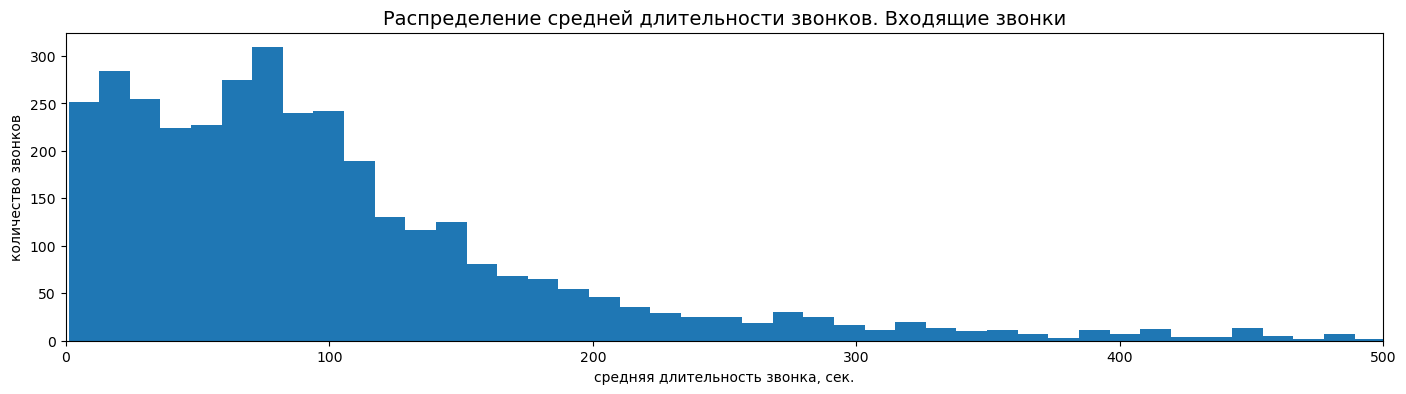

In [249]:
hist_timecall(calls_in, 
              'Распределение средней длительности звонков. Входящие звонки')

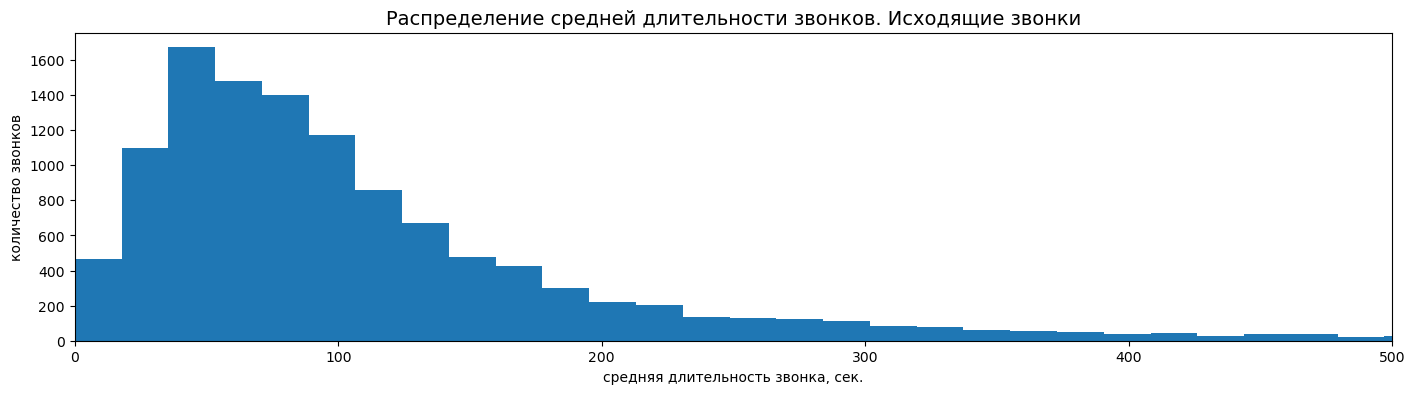

In [250]:
hist_timecall(calls_out, 
              'Распределение средней длительности звонков. Исходящие звонки')

### Гипотеза о среднем количестве звонков

Нулевая гипотеза: среднее количество внешних звонков (без учета пропущенных) для каждого оператора составляет 16 в день.<br>

Альтернативная гипотеза: среднее количество внешних звонков (без учета пропущенных) для каждого оператора составляет более 16 в день.

Для проверки двусторонней гипотезы о равенстве среднего генеральной совокупности некоторому значению используется метод scipy.stats.ttest_1samp(array, popmean). Для одностороннего теста нужно разделить получившееся p-value пополам, либо использовать параметр alternative.

In [251]:
# создадим выборку для проверки гипотезы
calls_per_day = (
    data.query('is_missed_call == False and internal==False')
    .groupby(['operator_id', 'date'])['calls_count']
    .sum()
    .reset_index()
)
calls_per_day = calls_per_day.groupby('operator_id')['calls_count'].mean()
calls_per_day.head()

operator_id
879896    14.217391
879898    61.098765
880020     1.692308
880022     2.358974
880026    20.571429
Name: calls_count, dtype: float64

In [252]:
mean_value = 16 #предполагаемое среднее количество звонков в день

alpha = 0.01 #критический уровень статистической значимости
results = st.ttest_1samp(
    calls_per_day, 
    mean_value, 
    alternative='greater') # тест односторонний
print('p-значение:', results.pvalue)

# тест односторонний вправо (больше):
# отвергаем гипотезу только тогда, когда выборочное среднее значимо больше предполагаемого значения
if (results.pvalue < alpha) and (calls_per_day.mean() > mean_value):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")


p-значение: 0.510969492647538
Не отвергаем нулевую гипотезу


In [253]:
print('Cреднее количество внешних звонков (без учета пропущенных) для каждого оператора:', 
      round(calls_per_day.mean(), 2))

Cреднее количество внешних звонков (без учета пропущенных) для каждого оператора: 15.97


Гипотеза о среднем количестве внешних звонков (без учета пропущенных) для каждого оператора, равном 16 в день, не отвергнута.

## Поиск неэффективных операторов

### Пропущенные вызовы

Первый критерий: много пропущенных внешних входящих звонков (в случае, если был назначен оператор). <br>
Условие: более 5% от всех внешних входящих звонков являются пропущенными. <br>
Дополнительное условие: общее количество внешних входящих звонков у оператора более 20 (минимум для выявления 5%).

In [254]:
# общее число пропущенных внешних входящих звонков для каждого оператора
missed_calls = (
    data.query('internal==False and direction=="in" and is_missed_call==True')
    .groupby('operator_id')['calls_count'].sum().reset_index()
    .rename(columns={'calls_count':'missed_calls'})
)
print('Количество операторов:', len(missed_calls))
missed_calls.head()

Количество операторов: 230


,operator_id,missed_calls
0,882680,3
1,882684,4
2,882686,6
3,882690,2
4,884408,3


In [255]:
# общее число внешних входящих звонков для каждого оператора, у которого есть пропущенные звонки
in_calls = (
    data.query('internal==False and direction=="in" and operator_id in @missed_calls.operator_id')
    .groupby('operator_id')['calls_count'].sum().reset_index()
    .rename(columns={'calls_count':'in_calls'})
)

#проверка совпадения числа операторов
if len(in_calls) == len(missed_calls):
    pass
else:
    print('Количество операторов не совпадает ({})'.format(len(in_calls)))
    
in_calls.head()

,operator_id,in_calls
0,882680,97
1,882684,613
2,882686,766
3,882690,171
4,884408,31


In [256]:
# объединеним таблицы и добавим столбец с процентом пропущенных вызовов для каждого оператора
missed_calls_prc = in_calls.merge(missed_calls, how='inner', on='operator_id')
missed_calls_prc['missed_calls_prc'] = round(missed_calls_prc['missed_calls'] / 
                                             missed_calls_prc['in_calls'] * 100, 2)
#сортировка
missed_calls_prc = missed_calls_prc.sort_values(by='missed_calls_prc', ascending=False)
missed_calls_prc

,operator_id,in_calls,missed_calls,missed_calls_prc
210,948756,1,1,100.00
54,904344,4,3,75.00
92,913886,2,1,50.00
65,906392,18,7,38.89
155,937432,3,1,33.33
...,...,...,...,...
45,901884,554,1,0.18
33,899082,655,1,0.15
109,919792,750,1,0.13
110,919794,1136,1,0.09


In [257]:
print('Медианный процент пропущенных звонков:', 
      round(missed_calls_prc['missed_calls_prc'].median(), 2))
print('Средний процент пропущенных звонков:', 
      round(missed_calls_prc['missed_calls_prc'].mean(), 2))

Медианный процент пропущенных звонков: 1.9
Средний процент пропущенных звонков: 5.43


In [258]:
# применим условие общего количества внешних входящих вызовов у оператора
# и процента пропущенных звонков
# а также создадим список неэффективных операторов
c_number = 20
miss_prc = 5

bad_missed_op = (
    missed_calls_prc.query(
        'in_calls > @c_number and missed_calls_prc > @miss_prc')
    [['operator_id', 'missed_calls_prc']]
)

display(bad_missed_op.head(3))
print('Количество операторов:', len(bad_missed_op))

,operator_id,missed_calls_prc
72,906412,26.92
56,905300,24.00
154,937368,18.18


Количество операторов: 22


Итоговое значение критерия ужесточено до 5% пропущенных вызовов. Это соответствует среднему значению, но в 2,5 превышает медиану.<br>
Добавлено дополнительное условие по минимальному количеству звонков.

### Долгий ответ

Второй критерий: долгое ожидание ответа при входящих внешних звонках. <br>
Условие: среднее время ожидания более 30 секунд на звонок.

In [259]:
wait_table = (
    data.query('internal==False and direction=="in"')
    .groupby('operator_id')['mean_wait_duration'].mean().reset_index()
    .rename(columns={'calls_count':'mean_wait_duration'})
).sort_values(by='mean_wait_duration', ascending=False).round(2)

wait_table

,operator_id,mean_wait_duration
196,905842,115.50
307,917680,100.00
120,899900,71.00
222,907174,65.19
699,960296,63.00
...,...,...
550,940430,0.87
399,926872,0.86
661,952982,0.83
629,949420,0.75


In [260]:
print('Медианное время ожидания:', 
      round(wait_table['mean_wait_duration'].median(), 2))
print('Среднее время ожидания:', 
      round(wait_table['mean_wait_duration'].mean(), 2))

Медианное время ожидания: 14.7
Среднее время ожидания: 17.95


In [261]:
# применим условие и получим список неэффективных операторов
wait_time = 30    # в секундах

bad_wait_op = wait_table.query('mean_wait_duration > @wait_time')
display(bad_wait_op.head(3))
print('Количество операторов:', len(bad_wait_op))

,operator_id,mean_wait_duration
196,905842,115.5
307,917680,100.0
120,899900,71.0


Количество операторов: 100


Итоговое значение критерия ужесточено до 30 сек.

### Количество исходящих звонков

Третий критерий: мало исходящих звонков — в случае колл-центров, специализирующихся на обзвонах. <br>
Условие: оператор совершает менее 16 исходящих внешних звонков в день (в среднем). <br>
Дополнительное условие: не считаем пропущенные звонки.

In [262]:
out_call_table = (
    data.query('internal==False and direction=="out" and type=="out" and is_missed_call==False')
    .groupby('operator_id')['calls_count'].mean().reset_index()    # группировку по дням не применяем, т.к. условия выборки достаточны
).sort_values(by='calls_count').round(2)

out_call_table

,operator_id,calls_count
681,973120,1.00
613,953362,1.00
615,953460,1.00
625,957022,1.00
632,958440,1.00
...,...,...
559,945904,123.67
375,929426,156.19
203,908640,319.58
362,925922,431.46


In [263]:
print('Медианное количество исходящих звонков:', 
      round(out_call_table['calls_count'].median(), 2))
print('Среднее количество исходящих звонков:', 
      round(out_call_table['calls_count'].mean(), 2))

Медианное количество исходящих звонков: 7.0
Среднее количество исходящих звонков: 19.63


In [264]:
# применим условие и получим список неэффективных операторов
c_count = 16

bad_call_op = out_call_table.query('calls_count < @c_count')

display(bad_call_op.head(3))
print('Количество операторов:', len(bad_call_op))

,operator_id,calls_count
681,973120,1.0
613,953362,1.0
615,953460,1.0


Количество операторов: 461


Итоговое значение критерия соответствует первоначальному. Добавлено дополнительное условие.

Следует отметить, что полученные в виде датасета данные говорят о том, что операторы делают довольно мало звонков относительно их длительности. У такого явления должны быть причины. Например, помимо непосредственно звонков операторы могут собирать предварительную информацию для звонка, выполнять какие-то действия по результатам звонка.
Также возможно, что у операторов нет причин делать много звонков. Это может быть связано с особенностями деятельности колл-центров.
При этом, 16 звонков в день - это 2 звонка в час при 8-часовом рабочем дне, что выглядит как оптимальное число в случае наличия дополнительных задач. 

### Внутренние звонки

Четвертый критерий: большое количество исходящих внутренних вызовов (не пропущенных). <br>
Условие: количество исходящих внутренних звонков составляет более 30% от числа внешних звонков оператора. <br>
Дополнительное условие: не считаем пропущенные звонки; общее количество внешних звонков у оператора более 3.

In [265]:
# исходящие внутренние звонки
internal_call_table = (
    data.query('internal==True and direction=="out" and is_missed_call==False')
    .groupby('operator_id')['calls_count'].mean().reset_index()
    .rename(columns={'calls_count':'int_calls'})
).round(2)

#internal_call_table

In [266]:
# внешние звонки (входящие и исходящие)
external_call_table = (
    data.query('internal==False and is_missed_call==False')
    .groupby('operator_id')['calls_count'].mean().reset_index()
    .rename(columns={'calls_count':'ext_calls'})
).round(2)

#external_call_table

In [267]:
# объединеним таблицы и добавим столбец с процентным соотношением внутренних и внешних звонков для каждого оператора
calls_table = external_call_table.merge(internal_call_table, how='inner', on='operator_id')
calls_table['calls_prc'] = round(
    calls_table['int_calls'] / calls_table['ext_calls'] * 100, 2)
#сортировка
calls_table = calls_table.sort_values(by='calls_prc', ascending=False)
calls_table

,operator_id,ext_calls,int_calls,calls_prc
83,907986,1.00,9.36,936.00
254,958440,1.00,5.75,575.00
255,958444,1.00,4.38,438.00
95,915358,1.40,5.83,416.43
65,906412,2.03,8.27,407.39
...,...,...,...,...
205,945324,56.08,1.00,1.78
203,945298,56.95,1.00,1.76
272,965542,78.80,1.00,1.27
206,945900,111.19,1.00,0.90


In [268]:
print('Медианное процентное соотношение внутренних и внешних звонков:', 
      round(calls_table['calls_prc'].median(), 2))
print('Среднее процентное соотношение внутренних и внешних звонков:', 
      round(calls_table['calls_prc'].mean(), 2))

Медианное процентное соотношение внутренних и внешних звонков: 40.18
Среднее процентное соотношение внутренних и внешних звонков: 74.09


In [269]:
# применим условие общего количества внешних исходящих звонков у оператора
# и процента пропущенных звонков
# а также создадим список неэффективных операторов
ext_call_min = 3
calls_prc_max = 30    # процентов

bad_int_op = calls_table.query('ext_calls > @ext_call_min and calls_prc > @calls_prc_max')

display(bad_int_op.head(3))
print('Количество операторов:', len(bad_int_op))

,operator_id,ext_calls,int_calls,calls_prc
169,937864,3.56,8.00,224.72
253,958434,3.11,5.45,175.24
58,906396,3.46,5.36,154.91


Количество операторов: 43


Итоговое значение критерия ужесточено до 30%, добавлены дополнительные условия.

### Неэффективные операторы по совокупности критериев

Первые два критерия в большей степени применимы к колл-центрам, специализирующимся на обработке входящих звонков. <br>
Третий критерий, напротив, применим исключительно для колл-центров, специализирующихся на обзвонах. <br>
Четвертый критерий применим для всех типов колл-центров, но является скорее вспомогательным.<br>

Таким образом, важно предоставить возможность выбора критериев оценки эффективности операторов, для их использования в зависимости от типа колл-центра и решаемых задач.

Проверим, есть ли операторы, подпадающие сразу под все критерии неэффективности.

In [270]:
display(data.query('operator_id in @bad_missed_op.operator_id \
           and operator_id in @bad_wait_op.operator_id \
           and operator_id in @bad_call_op.operator_id \
           and operator_id in @bad_int_op.operator_id').groupby('operator_id')[['user_id', 'type']].max().head(3))
print('Количество операторов:', len(data.query('operator_id in @bad_missed_op.operator_id \
           and operator_id in @bad_wait_op.operator_id \
           and operator_id in @bad_call_op.operator_id \
           and operator_id in @bad_int_op.operator_id').groupby('operator_id')[['user_id', 'type']].max()))

,user_id,type
operator_id,,


Количество операторов: 0


Таких операторов нет.

Проверим, есть ли операторы, подпадающие под первые два критерия - много пропущенных звонков и долгое время ожидания.

In [271]:
display(data.query('operator_id in @bad_missed_op.operator_id \
           and operator_id in @bad_wait_op.operator_id').groupby('operator_id')[['user_id', 'type']].max().head(3))
print('Количество операторов:', len(data.query('operator_id in @bad_missed_op.operator_id \
           and operator_id in @bad_wait_op.operator_id').groupby('operator_id')[['user_id', 'type']].max()))

,user_id,type
operator_id,,
944216,167977,in
944218,167977,in
944220,167977,in


Количество операторов: 5


Пять операторов.

Проверим, есть ли операторы, подпадающие третий и четвертый критерии - мало исходящих внешних звонков и много внутренних звонков.

In [272]:
display(data.query('operator_id in @bad_call_op.operator_id \
           and operator_id in @bad_int_op.operator_id').groupby('operator_id')[['user_id', 'type']].max().head(3))
print('Количество операторов:', len(data.query('operator_id in @bad_call_op.operator_id \
           and operator_id in @bad_int_op.operator_id').groupby('operator_id')[['user_id', 'type']].max()))

,user_id,type
operator_id,,
879896,166406,out
887276,166485,out
905104,167176,out


Количество операторов: 43


Сорок три оператора.

Вывод: под одиночные критерии подпадают от 43 до 461 оператора. Под рассмотренные совокупности критериев - от 0 до 43.<br>

Под критерии неэффективности чаще подпадают операторы из колл-центров, специализирующихся на обзвонах. Причинами являются как большее число таких операторов, так и особенности критериев и пороговых значений неэффективности.

---

## Выводы

- в рамках предобработки данных колл-центры разделены на две специализации - прием звонков и обзвоны, на основании соотношения входящих и исходящих звонков.
- в датасете содержатся данные за период с 02.08.2019 по 28.11.2019 в отношении 290 колл-центров и 1090 операторов.
- в отношении половины колл-центров имеются данные не более чем за 22 дня. Колл-центров, данные по которым имеются за весь период исследования (118 дней), нет.
- присоединение колл-центров происходило равномерно в течение всего периода исследования. На момент окончания исследования большинство колл-центров оставались активными.
- 98% звонков являются внешними.
- 95% внутренних звонков являются исходящими.
- 85% всех звонков являются исходящими (76%, если не считать пропущенные).
- пропущенные звонки составляют 37% от общего количества. Практически все пропущенные звонки являются исходящими.
- специализации колл-центров в датасете представлены практически равным количеством колл-центров (43% / 57%). При этом, 77% операторов относятся к колл-центрам, специализирующиеся на обзвонах. Также такие колл-центры совершают 94% от всех звонков.
- в среднем, в колл-центрах, специализирующихся на обзвонах, работают 5 операторов, а в колл-центрах, специализирующихся на приеме звонков - 2 оператора. Самые крупные колл-центры имеют соответственно 50 и 12 операторов.
- среднее количество исходящих внешних звонков в день на оператора более чем в три раза выше, чем аналогичных входящих звонков - 17,8 против 4,9.
- медианная длительность звонка составляет 80,2 секунд. Медианная длительность внешних входящих и исходящих звонков примерно равна, длительность внутренних исходящих звонков больше, чем входящих.
- медианное время ожидания внешнего звонка составляет 15,6 сек., при входящем вызове - 13 сек., при исходящем - 16,5 сек.
- в целом, колл-центры чаще всего выбирают тариф C (54%), затем следуют B (35%) и A (11%).
- колл-центры, специализирующиеся на приеме звонков, чаще выбирают тариф C (69%). Колл-центры, специализирующиеся на обзвонах, в равной степени (по 43%) выбирают тарифы C и B.

Проверены две статистические гипотезы.
1. Гипотеза о равенстве длительности входящих и исходящих звонков отвергнута. Разница средней длительности входящих (111 сек.) и исходящих (133 сек.) звонков оказалась статистически значимой.
2. Гипотеза о среднем количестве внешних звонков (без учета пропущенных) для каждого оператора, равном 16 в день, не отвергнута.

Итоговые критерии неэффективности операторов:
1. Более 5% от всех внешних входящих звонков являются пропущенными при общем количестве внешних входящих звонков более 20 (выявлено 22 оператора).
2. Среднее время ожидания ответа при входящих внешних звонках более 30 секунд (выявлено 100 операторов). 
3. Оператор совершает менее 16 исходящих внешних звонков в день (в случае колл-центров, специализирующихся на обзвонах) (выявлен 461 оператор)
4. Количество исходящих внутренних звонков составляет более 30% от числа внешних звонков оператора, при общем количестве внешних звонков более 3 (выявлено 43 оператора).

Операторов, подпадающих сразу под все критерии неэффективности, не обнаружено.<br>
Под первые два критерия - много пропущенных звонков и долгое время ожидания, подпадают 5 операторов.<br>
Под третий и четвертый критерии - мало исходящих внешних звонков и много внутренних звонков, подпадают 43 оператора.<br>

Под критерии неэффективности чаще подпадают операторы из колл-центров, специализирующихся на обзвонах. Причинами являются как большее число таких операторов, так и особенности критериев и пороговых значений неэффективности.

## Tableau

ТЗ для дашборда:
1. Построить гистограмму распределения длительности звонков;
2. Построить круговую диаграмму, отображающую соотношение кол-ва внутренних и внешних вызовов;
3. Добавить фильтр дашборда по направлению вызовов.

**Ссылка на дашборд:** https://public.tableau.com/views/Telecom_16779344677580/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link